<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

#графики в svg выглядят более четкими
#%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:

#Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

#базовые библиотеки машинного обучения
from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from catboost import CatBoostRegressor
import xgboost
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

In [4]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

In [5]:
filename = '/datasets/taxi.csv'
df = pd.read_csv(filename, index_col=[0], parse_dates=[0])
df.sort_index(ascending=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


О наборе данных
Первый признак - дата с детальзацией до секунд, второй-количество заказов. Срез представлен за 2018 год в период с марта по август, т.е. у нас имеется сет данных за 5 месяцев. Объем данных = 26 тысяч объектов.

In [8]:
print(df.index.is_monotonic)

True


In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
df.shape

(4416, 1)

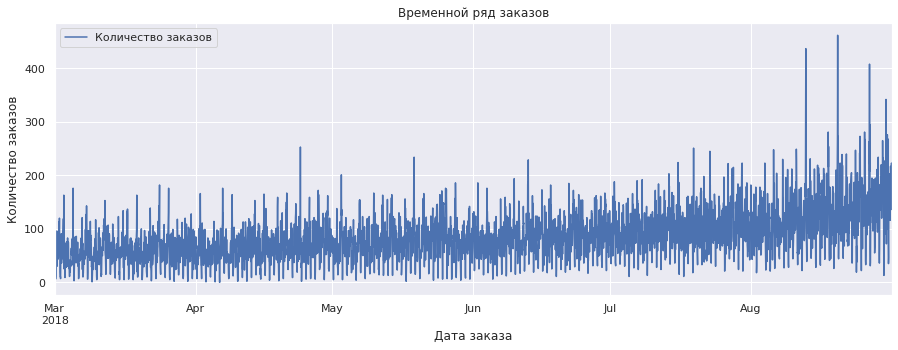

In [11]:
df.plot()
plt.title('Временной ряд заказов');
plt.ylabel('Количество заказов')
plt.xlabel('Дата заказа')
plt.legend(['Количество заказов'], loc = 2);

In [12]:
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['day_of_week'] = df.index.dayofweek
#df['hour'] = df.index.hour
#df.head()
#copy_table = df.copy() # для моделей 

In [13]:


#df['rolling_mean'].plot();
#plt.title('rolling_mean');

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [15]:
make_features(df, 10, 168)

,num_orders,hour,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,154.297619
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,154.434524
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,154.285714


In [16]:
#df_d = df.resample('1D').sum()

In [17]:
#df_d.plot();

In [18]:
#df_w = df.resample('1W').sum()

In [19]:
#df_w.plot();

Вывод Сет данных загружен, преобразован в dataframe, проведено ресемплирование с детализацией до часа и агрегацией по средним значениям.

## Анализ

In [20]:
decomposed = seasonal_decompose(df['num_orders'])

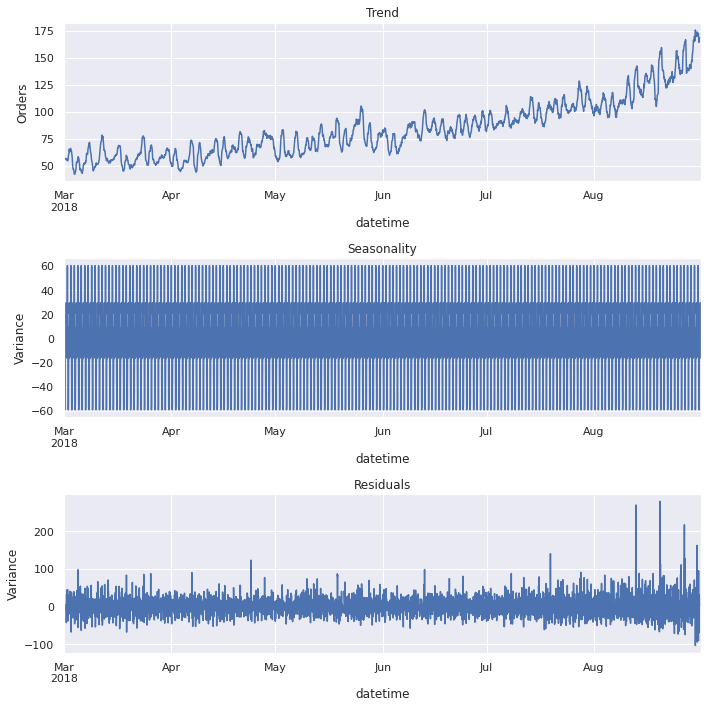

In [21]:
plt.figure(figsize=(10,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Orders')
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.ylabel('Variance')
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.ylabel('Variance')
plt.title('Residuals')

plt.tight_layout()
plt.show()

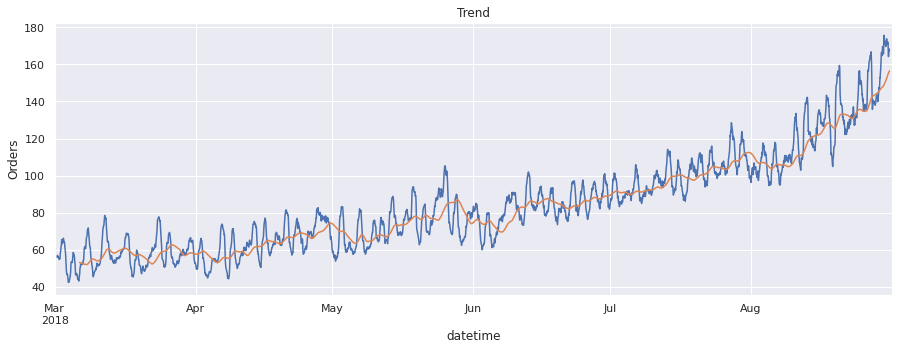

In [22]:
decomposed.trend.plot();
#decomposed.trend.rolling(30).mean().plot();
#decomposed.trend.rolling(60).mean().plot();
decomposed.trend.rolling(120).mean().plot();
plt.ylabel('Orders')
plt.title('Trend');

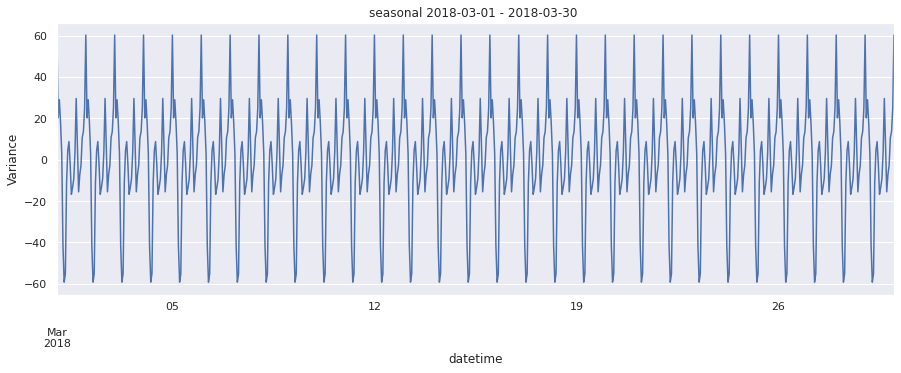

In [23]:
decomposed.seasonal['2018-03-01 00:00':'2018-03-30 00:00'].plot();
plt.ylabel('Variance')
plt.title('seasonal 2018-03-01 - 2018-03-30 ');

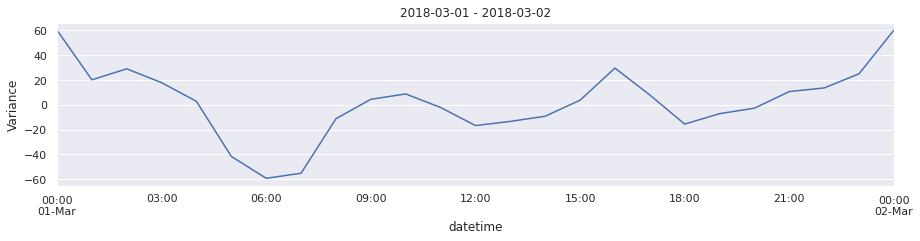

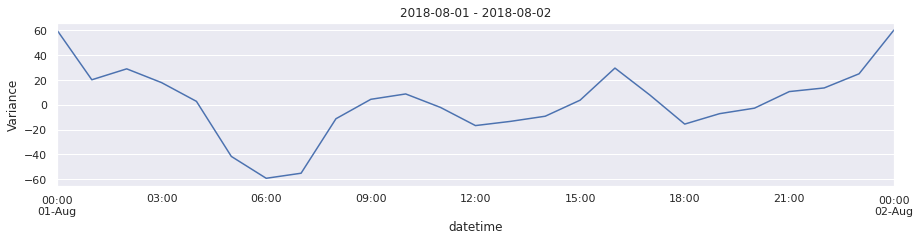

In [24]:
plt.figure(figsize=(15,3))
decomposed.seasonal['2018-03-01 00:00':'2018-03-02 00:00'].plot()
plt.ylabel('Variance')
plt.title('2018-03-01 - 2018-03-02')
plt.show()
plt.figure(figsize=(15,3))
decomposed.seasonal['2018-08-01 00:00':'2018-08-02 00:00'].plot()
plt.ylabel('Variance')
plt.title('2018-08-01 - 2018-08-02')
plt.show()

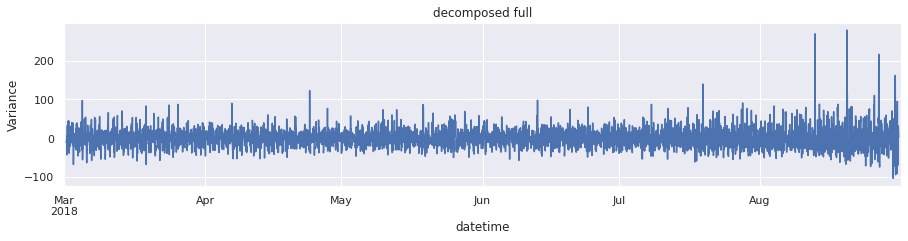

In [25]:
plt.figure(figsize=(15,3))
decomposed.resid.plot()
plt.title('decomposed full')
plt.ylabel('Variance')
plt.show()


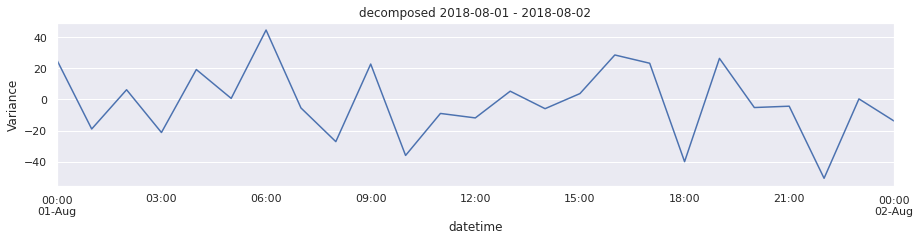

In [26]:
plt.figure(figsize=(15,3))
decomposed.resid['2018-08-01 00:00':'2018-08-02 00:00'].plot()
plt.ylabel('Variance')
plt.title('decomposed 2018-08-01 - 2018-08-02')
plt.show()


Вывод Тренд восходящий, сезональность присутствует в течении дня. Пики количества заказов приходятся на утро с 9-11, конец рабочего дня 16-18 и максимальне значение в районе полуночи.

In [28]:
df = df.dropna()
df

,num_orders,hour,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,8,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,54.226190
2018-03-08 01:00:00,78,1,8,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,54.339286
2018-03-08 02:00:00,65,2,8,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,54.297619
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,54.261905
2018-03-08 04:00:00,60,4,8,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,154.297619
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,154.434524
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,154.285714


## Обучение

In [29]:

features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [30]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3823, 14)
(425, 14)
(3823,)
(425,)


Масштабирование

In [31]:
scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns = x_train.columns)
x_test =  pd.DataFrame(data = scaler.transform(x_test), columns = x_train.columns)

In [32]:
#df.head(4)

In [33]:
x_train.head(4)

,hour,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
0,-1.658183,-0.871206,-0.007568,0.371383,1.220297,0.731578,-0.091694,-0.761460,0.503408,-0.813284,-0.864493,-0.734942,-0.941259,-1.389056
1,-1.513798,-0.871206,-0.007568,1.632878,0.370807,1.220794,0.733120,-0.091302,-0.762066,0.504134,-0.812821,-0.864119,-0.734482,-1.382467
2,-1.369413,-0.871206,-0.007568,-0.040533,1.632171,0.371103,1.222854,0.733507,-0.090590,-0.761621,0.504811,-0.812448,-0.863718,-1.384895
3,-1.225027,-0.871206,-0.007568,-0.375215,-0.041068,1.632765,0.372264,1.223238,0.735842,-0.089996,-0.761149,0.505160,-0.812024,-1.386975


In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, shuffle=False, test_size=0.1)

Линейная регрессия

In [35]:
%%time
model_linReg = LinearRegression()
model_linReg.fit(x_train, y_train)
predict_model_linReg = model_linReg.predict(x_valid)
rmse_model_linReg = mse(y_valid, predict_model_linReg)**(0.5)
mae_model_linReg = mean_absolute_error(y_valid, predict_model_linReg)
print('rmse =', rmse_model_linReg)
print('mae =', mae_model_linReg)

rmse = 40.31048527654946
mae = 29.80553153982162
CPU times: user 24.7 ms, sys: 24.1 ms, total: 48.8 ms
Wall time: 98.5 ms


In [36]:
index_table = 0
table = pd.DataFrame(columns=['name','rmse','mae'])
index_table +=1
table.loc[index_table] = ['Linear Regression', rmse_model_linReg, mae_model_linReg]
table

,name,rmse,mae
1,Linear Regression,40.310485,29.805532


Случайный лес

In [37]:
%%time

model_RandForest_t = RandomForestRegressor(random_state = 12345)

#Параметры для GridSearch
parametrs_grid = {'n_estimators': range(50, 100, 25),'max_depth' : range(50, 100, 25)}

tscv = tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
grid_cv = GridSearchCV(model_RandForest_t, cv=tscv,param_grid=parametrs_grid, scoring = "neg_root_mean_squared_error")

grid_cv.fit(x_train, y_train)


predict_model_RandForest_tuning = grid_cv.predict(x_valid)
rmse_model_RandForest_tuning = mse(y_valid, predict_model_RandForest_tuning)**(0.5)
mae_model_RandForest_tuning = mean_absolute_error(y_valid, predict_model_RandForest_tuning)

print('rmse =', rmse_model_RandForest_tuning)
print('mae =', mae_model_RandForest_tuning)

rmse = 31.475456674144585
mae = 22.45906005221932
CPU times: user 22.8 s, sys: 80.4 ms, total: 22.9 s
Wall time: 28.1 s


In [38]:
index_table +=1
table.loc[index_table] = ['Random Forest', rmse_model_RandForest_tuning, mae_model_RandForest_tuning]
table

,name,rmse,mae
1,Linear Regression,40.310485,29.805532
2,Random Forest,31.475457,22.459060



SGDRegressor

In [39]:
%%time
model_SGD = SGDRegressor()
model_SGD.fit(x_train, y_train)
predict_model_SGD = model_SGD.predict(x_valid)
rmse_model_SGD = mse(y_valid, predict_model_SGD)**(0.5)
mae_model_SGD = mean_absolute_error(y_valid, predict_model_SGD)
print('rmse =', rmse_model_SGD)
print('mae =', mae_model_SGD)

rmse = 40.25916958700324
mae = 29.70998863426306
CPU times: user 15.2 ms, sys: 4 µs, total: 15.2 ms
Wall time: 26.9 ms


In [40]:
index_table +=1
table.loc[index_table] = ['SGD', rmse_model_SGD, mae_model_SGD]
table

,name,rmse,mae
1,Linear Regression,40.310485,29.805532
2,Random Forest,31.475457,22.459060
3,SGD,40.259170,29.709989


CatBoostRegressor

In [41]:

#%%time
#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [5, 15],
#        'l2_leaf_reg': [1, 30]\
#       }
#
#model_cat = CatBoostRegressor(loss_function="RMSE")
#
#grid_search_result = model_cat.grid_search(grid,
#                                       X=x_train,
#                                       y=y_train,
#                                       plot=True)

In [42]:
#grid_search_result['params']

In [43]:
%%time
model_cat = CatBoostRegressor(loss_function="RMSE", depth=5,\
                              l2_leaf_reg=1, learning_rate=0.03,\
                              iterations=10000
                             )
model_cat.fit(x_train, y_train, verbose=100);

0:	learn: 35.7126634	total: 67.7ms	remaining: 11m 16s
100:	learn: 22.7864904	total: 335ms	remaining: 32.9s
200:	learn: 20.8769680	total: 588ms	remaining: 28.7s
300:	learn: 19.6927777	total: 834ms	remaining: 26.9s
400:	learn: 18.6522790	total: 1.08s	remaining: 25.8s
500:	learn: 17.9066915	total: 1.32s	remaining: 25s
600:	learn: 17.2279534	total: 1.57s	remaining: 24.6s
700:	learn: 16.6404907	total: 1.82s	remaining: 24.2s
800:	learn: 16.0540294	total: 2.06s	remaining: 23.7s
900:	learn: 15.5562422	total: 2.35s	remaining: 23.7s
1000:	learn: 15.0957389	total: 2.63s	remaining: 23.6s
1100:	learn: 14.6321355	total: 2.92s	remaining: 23.6s
1200:	learn: 14.2413281	total: 3.2s	remaining: 23.5s
1300:	learn: 13.8558828	total: 3.48s	remaining: 23.3s
1400:	learn: 13.4697973	total: 3.74s	remaining: 22.9s
1500:	learn: 13.1253946	total: 3.97s	remaining: 22.5s
1600:	learn: 12.8004487	total: 4.22s	remaining: 22.1s
1700:	learn: 12.4471406	total: 4.46s	remaining: 21.8s
1800:	learn: 12.1416863	total: 4.76s	rem

In [44]:
%%time
predict_model = model_cat.predict(x_valid, verbose=0)
rmse_model_cat = mse(y_valid, predict_model)**(0.5)
mae_model_cat = mean_absolute_error(y_valid, predict_model)
print('rmse =', rmse_model_cat)
print('mae =', mae_model_cat)

rmse = 32.01359945692668
mae = 22.717547665489953
CPU times: user 10.2 ms, sys: 100 µs, total: 10.3 ms
Wall time: 8.07 ms


In [45]:
index_table +=1
table.loc[index_table] = ['CatBoost', rmse_model_cat, mae_model_cat]
table

,name,rmse,mae
1,Linear Regression,40.310485,29.805532
2,Random Forest,31.475457,22.459060
3,SGD,40.259170,29.709989
4,CatBoost,32.013599,22.717548


## Тестирование

In [46]:
table

,name,rmse,mae
1,Linear Regression,40.310485,29.805532
2,Random Forest,31.475457,22.459060
3,SGD,40.259170,29.709989
4,CatBoost,32.013599,22.717548


In [47]:
table[table['rmse'] == table['rmse'].min()]

,name,rmse,mae
2,Random Forest,31.475457,22.45906


In [48]:
table[table['rmse'] == table['rmse'].max()]

,name,rmse,mae
1,Linear Regression,40.310485,29.805532


In [49]:
predict_model_RandForest_test = grid_cv.predict(x_test)
rmse_model_RandForest_test = mse(y_test, predict_model_RandForest_test)**(0.5)
print('Показатель RMSE для модели RandForest', rmse_model_RandForest_test)

Показатель RMSE для модели RandForest 47.560622803026504


In [50]:
#predict_model_test = model_cat.predict(x_test, verbose=0)
#rmse_model_cat_test = mse(y_test, predict_model_test)**(0.5)

#print('Показатель RMSE для модели CatBoostRegressor', rmse_model_cat_test)

In [51]:
#predict_model_SGD = model_SGD.predict(x_test)
#rmse_model_SGD = mse(y_test, predict_model_SGD)**(0.5)
#print('Показатель RMSE для модели SGD', rmse_model_SGD)

In [52]:
#predict_model_linReg = model_linReg.predict(x_test)
#rmse_model_linReg = mse(y_test, predict_model_linReg)**(0.5)
#print('Показатель RMSE для модели linReg', rmse_model_linReg)

## Общий вывод:

Результаты получись лучше чем, если бы использовалась рандомное значение,В проекте воспользовался основными моделями, лучшие показатели RMSE получил при использовании Random Forest, CatBoost показал схожий результат, но на предсказании работает чуть быстрее. В зависимости от препочтений заказчика стоит остановиться на этих двух моделях

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Почему важно использовать в данной задаче именно GridSearchCV?


</div>